In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.spatial.distance import euclidean
from sklearn.cluster import DBSCAN
from collections import Counter

path_spektri = '/home/jurij/Documents/Faks/PSUF/nal_2/spektri/'
path = '/home/jurij/Documents/Faks/PSUF/nal_2/'

# LOAD DATA AND LABELS

Compute outlier numbers

In [37]:
spec_ids = np.arange(1,10000,1)
spectra = [np.loadtxt(path_spektri + f"{sid}.dat", comments="#") for sid in spec_ids]
X = np.array(spectra)


# Compute distance from mean for all spectra (assuming X shape = [n, p])
mean_spec = np.mean(X, axis=0)
distances = np.linalg.norm(X - mean_spec, axis=1)

# Determine threshold for top 0.5% most deviant
threshold = np.percentile(distances, 99.5)
outlier_indices = np.where(distances >= threshold)[0]

print(f"Number of outliers: {len(outlier_indices)}")

Number of outliers: 50


In [38]:
# Load training labels (MAB, BIN, etc.)
type_data = np.loadtxt(path + "learning_set_types.txt", dtype=str)
type_ids = type_data[:, 0].astype(int)
type_labels = type_data[:, 1]

# Match labels to loaded spectra
labels = []
for sid in spec_ids:
    if sid in type_ids:
        idx = np.where(type_ids == sid)[0][0]
        labels.append(type_labels[idx])
    else:
        labels.append("UNKNOWN")
labels = np.array(labels)

# Color map
color_map = {
    "MAB": "tab:green",
    "BIN": "tab:blue",
    "TRI": "tab:cyan",
    "HFR": "tab:orange",
    "HAE": "tab:red",
    "CMP": "tab:purple",
    "DIB": "tab:brown",
    "UNKNOWN": "lightgray"
}
colors = [color_map.get(lbl, "gray") for lbl in labels]


# IDENTIFY OUTLIER SPECTRA

mean_spec = np.mean(X, axis=0)
distances = [euclidean(spec, mean_spec) for spec in X]
outlier_idx = np.argsort(distances)[-len(outlier_indices):]
print("Outlier spectra:", [spec_ids[i] for i in outlier_idx])

Outlier spectra: [1743, 4178, 2265, 776, 3770, 4176, 5632, 3435, 3446, 367, 2379, 4764, 997, 5215, 1367, 1515, 1813, 1309, 1362, 373, 2257, 1233, 328, 2544, 326, 1349, 865, 2295, 2816, 701, 442, 4564, 1350, 294, 434, 5683, 2313, 3189, 2419, 3827, 4055, 4563, 333, 1360, 2001, 1133, 4142, 1363, 2061, 2212]


# RUN t-SNE

In [39]:
# Try a few perplexity values to see the effect
for perplexity in [5, 20, 50]:
    print(f"\nRunning t-SNE with perplexity = {perplexity} ...")
    
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        learning_rate=200,
        n_iter=5000,
        init='random',
        random_state=42,
        verbose=1
    )
    
    X_tsne = tsne.fit_transform(X)


Running t-SNE with perplexity = 5 ...
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 9999 samples in 0.017s...
[t-SNE] Computed neighbors for 9999 samples in 70.440s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9999
[t-SNE] Computed conditional probabilities for sample 2000 / 9999
[t-SNE] Computed conditional probabilities for sample 3000 / 9999
[t-SNE] Computed conditional probabilities for sample 4000 / 9999
[t-SNE] Computed conditional probabilities for sample 5000 / 9999
[t-SNE] Computed conditional probabilities for sample 6000 / 9999
[t-SNE] Computed conditional probabilities for sample 7000 / 9999
[t-SNE] Computed conditional probabilities for sample 8000 / 9999
[t-SNE] Computed conditional probabilities for sample 9000 / 9999
[t-SNE] Computed conditional probabilities for sample 9999 / 9999
[t-SNE] Mean sigma: 0.134220
[t-SNE] KL divergence after 250 iterations with early exaggeration: 100.405502
[t-SNE] KL divergence after 5000 iterations: 2.4043

# VISUALIZE t-SNE RESULT

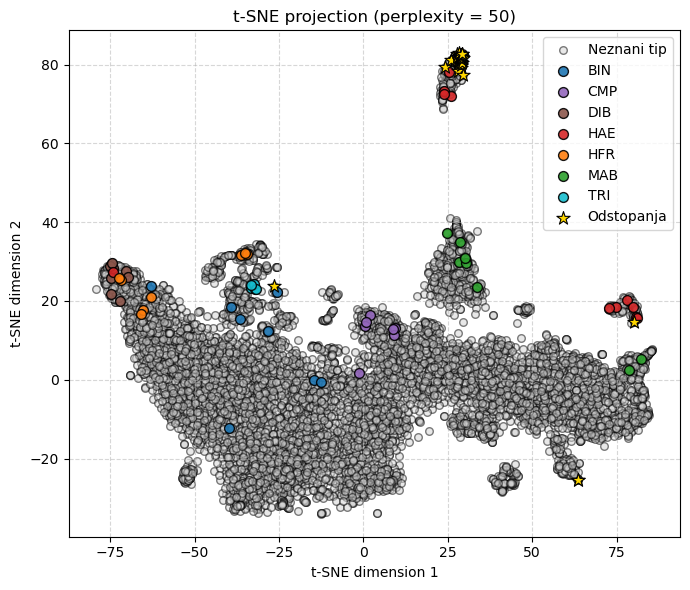

In [ ]:
plt.figure(figsize=(7,6))
mask_unknown = labels == "UNKNOWN"
if np.any(mask_unknown):
    plt.scatter(X_tsne[mask_unknown, 0], X_tsne[mask_unknown, 1],
                label="Neznani tip",
                c="lightgray",
                s=30,
                alpha=0.5,
                edgecolors='k',
                zorder=1)

# Plot known star classes on top
for lbl in np.unique(labels):
    if lbl == "UNKNOWN":
        continue
    mask = labels == lbl
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                label=lbl,
                c=color_map.get(lbl, "gray"),
                s=50,
                edgecolors='k',
                alpha=0.9,
                zorder=2)

# Plot outliers on top of everything
plt.scatter(X_tsne[outlier_idx, 0], X_tsne[outlier_idx, 1],
            color='gold',
            s=100,
            marker='*',
            edgecolors='k',
            linewidth=0.8,
            label='Odstopanja',
            zorder=3)

plt.title(f"t-SNE projekcija (perplexity = {perplexity})")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Apply DBSCAN clustering

Number of detected clusters (excluding noise): 8


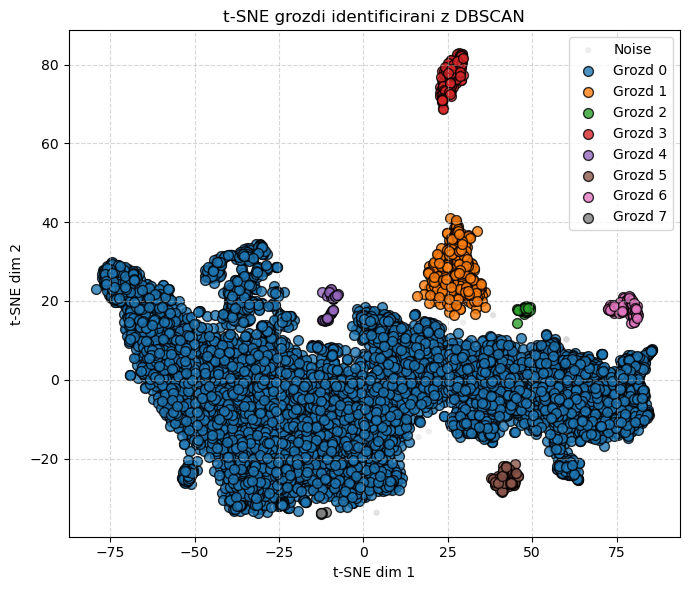

In [41]:
# eps → max distance for points in same cluster
# min_samples → minimum number of points to form a cluster
db = DBSCAN(eps=3, min_samples=5).fit(X_tsne)
cluster_labels = db.labels_  # -1 = noise/outliers

print("Number of detected clusters (excluding noise):", len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0))

# ======================================
# Visualize clusters
# ======================================
plt.figure(figsize=(7,6))
unique_clusters = np.unique(cluster_labels)
for cl in unique_clusters:
    mask = cluster_labels == cl
    if cl == -1:
        plt.scatter(X_tsne[mask,0], X_tsne[mask,1],
                    color="lightgray", s=20, label="Noise", alpha=0.4, edgecolors='none')
    else:
        plt.scatter(X_tsne[mask,0], X_tsne[mask,1],
                    s=50, alpha=0.8, label=f"Grozd {cl}", edgecolors='k')

plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.title("t-SNE grozdi identificirani z DBSCAN")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Cluster 0: contains 9012 spectra


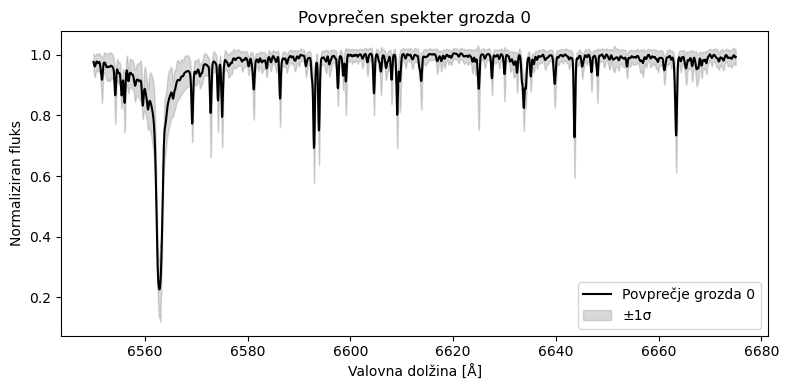

Cluster 1: contains 464 spectra


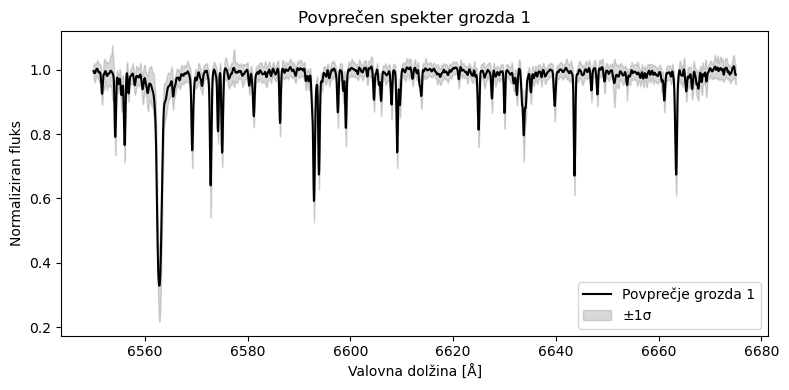

Cluster 2: contains 31 spectra


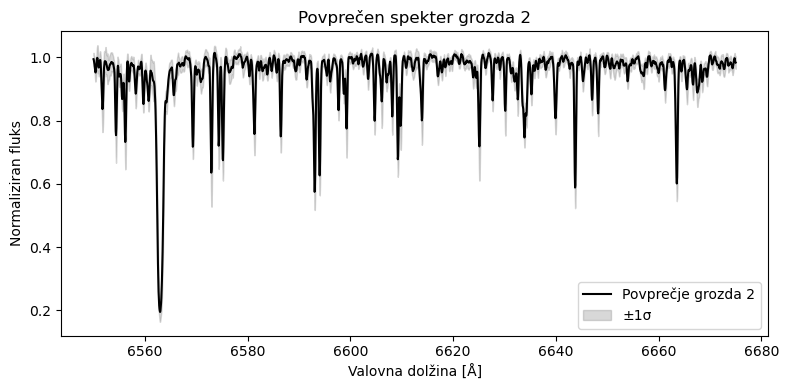

Cluster 3: contains 215 spectra


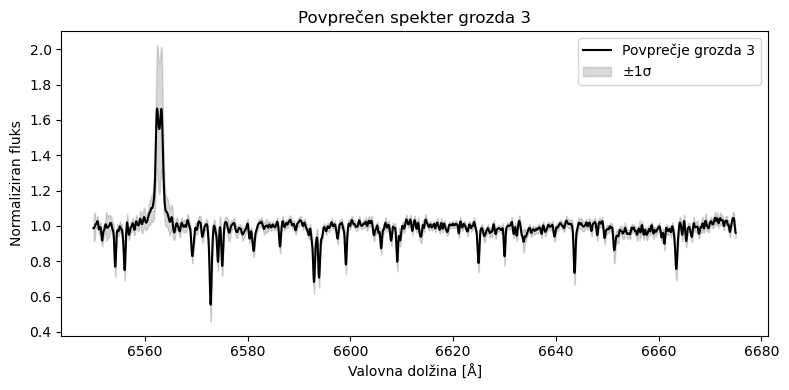

Cluster 4: contains 45 spectra


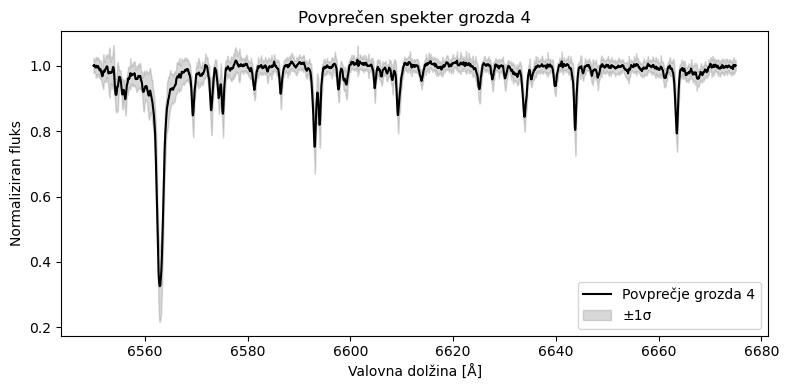

Cluster 5: contains 93 spectra


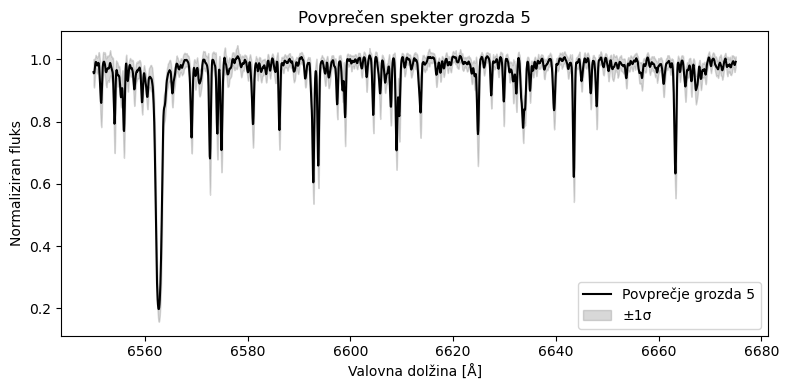

Cluster 6: contains 123 spectra


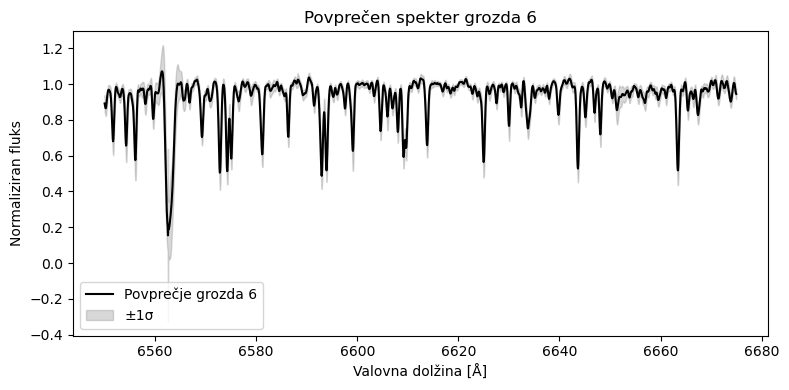

Cluster 7: contains 5 spectra


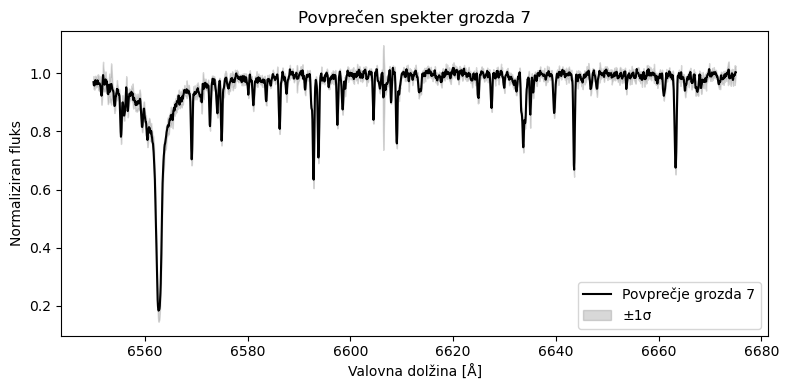

In [42]:
# Load wavelengths (for reference)
wav = np.loadtxt(path_spektri + "val.dat", comments="#")

# Group spectra by their cluster labels
unique_clusters = np.unique(cluster_labels)
for cl in unique_clusters:
    if cl == -1:  # Skip noise points
        continue
    cluster_indices = np.where(cluster_labels == cl)[0]
    print(f"Cluster {cl}: contains {len(cluster_indices)} spectra")

    # Compute the average (mean) spectrum for that cluster
    cluster_mean = np.mean(X[cluster_indices], axis=0)
    cluster_std = np.std(X[cluster_indices], axis=0)

    # Plot mean spectrum and variation
    plt.figure(figsize=(8,4))
    plt.plot(wav, cluster_mean, 'k-', label=f'Povprečje grozda {cl}')
    plt.fill_between(wav, cluster_mean - cluster_std, cluster_mean + cluster_std,
                     color='gray', alpha=0.3, label='±1σ')
    plt.xlabel('Valovna dolžina [Å]')
    plt.ylabel('Normaliziran fluks')
    plt.title(f'Povprečen spekter grozda {cl}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# how robust is the t-SNE clustering is when you remove the Hα region

Original wavelength points: 2084, after removing Hα region: 1751


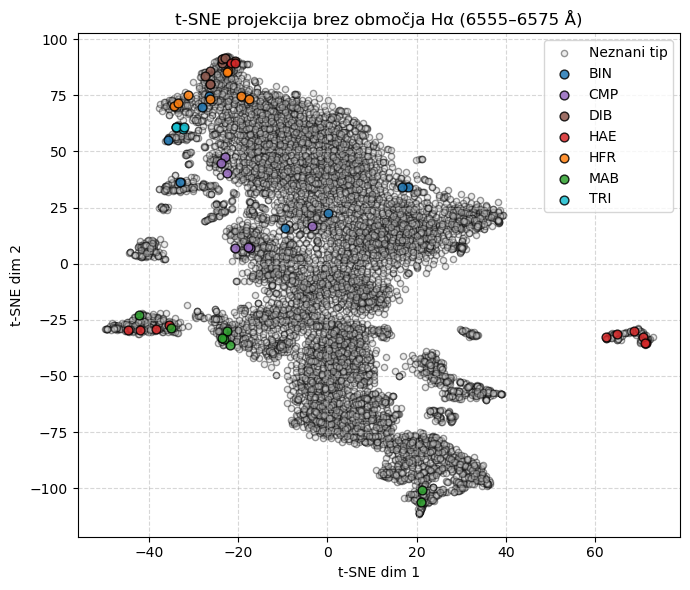

In [43]:
wav = np.loadtxt(path_spektri + "val.dat", comments="#")
spec_ids = np.arange(1,10000,1)
spectra = [np.loadtxt(path_spektri + f"{sid}.dat", comments="#") for sid in spec_ids]
X = np.array(spectra)

# Load class labels (MAB, BIN, HAE, etc.)
type_data = np.loadtxt(path + "learning_set_types.txt", dtype=str)
type_ids = type_data[:, 0].astype(int)
type_labels = type_data[:, 1]
labels = np.array([
    type_labels[np.where(type_ids == sid)[0][0]] if sid in type_ids else "UNKNOWN"
    for sid in spec_ids
])


# REMOVE Hα REGION

# Hα line is at ~6563 Å; exclude ±10 Å window (adjust as needed)
mask_no_Ha = (wav < 6555) | (wav > 6575)
wav_no_Ha = wav[mask_no_Ha]
X_no_Ha = X[:, mask_no_Ha]

print(f"Original wavelength points: {len(wav)}, after removing Hα region: {len(wav_no_Ha)}")


# RUN t-SNE WITHOUT Hα REGION

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=5000,
    init="random",
    random_state=42
)
X_tsne_no_Ha = tsne.fit_transform(X_no_Ha)


# VISUALIZE RESULTS

color_map = {
    "MAB": "tab:green",
    "BIN": "tab:blue",
    "TRI": "tab:cyan",
    "HFR": "tab:orange",
    "HAE": "tab:red",
    "CMP": "tab:purple",
    "DIB": "tab:brown",
    "UNKNOWN": "lightgray"
}
colors = [color_map.get(lbl, "gray") for lbl in labels]

plt.figure(figsize=(7,6))
# plot unknown first
mask_unknown = labels == "UNKNOWN"
if np.any(mask_unknown):
    plt.scatter(X_tsne_no_Ha[mask_unknown, 0], X_tsne_no_Ha[mask_unknown, 1],
                label="Neznani tip", c="lightgray", s=20, alpha=0.4, edgecolors='k', zorder=1)

# plot known classes
for lbl in np.unique(labels):
    if lbl == "UNKNOWN":
        continue
    mask = labels == lbl
    plt.scatter(X_tsne_no_Ha[mask, 0], X_tsne_no_Ha[mask, 1],
                label=lbl, c=color_map.get(lbl, "darkgray"),
                s=40, alpha=0.85, edgecolors='k', zorder=2)

plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.title("t-SNE projekcija brez območja Hα (6555–6575 Å)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [44]:
from sklearn.metrics import pairwise_distances

hae_mask = labels == "HAE"
if np.any(hae_mask):
    dists = pairwise_distances(X_tsne_no_Ha[hae_mask])
    mean_dist = np.mean(dists)
    print(f"Mean pairwise t-SNE distance among HAE stars: {mean_dist:.3f}")

Mean pairwise t-SNE distance among HAE stars: 76.322



Running DBSCAN with eps=2, min_samples=5
 → Found 13 clusters (excluding noise)


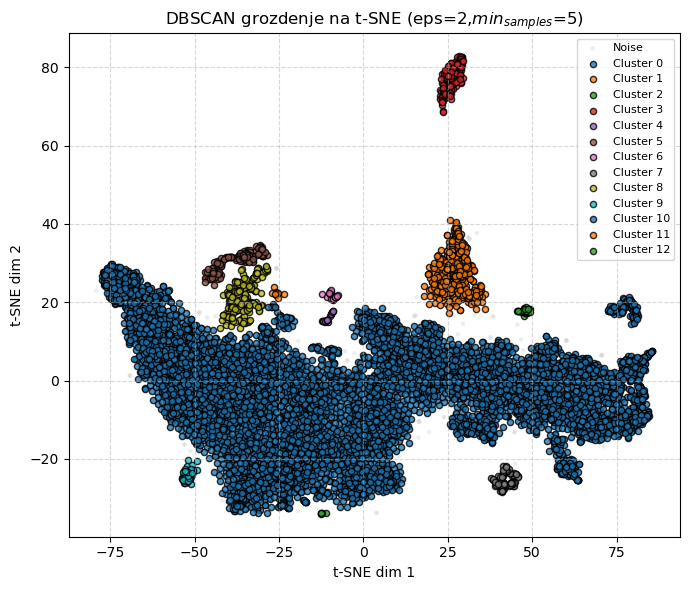

Cluster sizes: {0: 8536, 1: 456, 2: 30, 3: 215, 4: 19, 5: 172, 6: 26, 7: 92, 8: 192, -1: 67, 9: 55, 10: 123, 11: 11, 12: 5}

Running DBSCAN with eps=3, min_samples=10
 → Found 8 clusters (excluding noise)


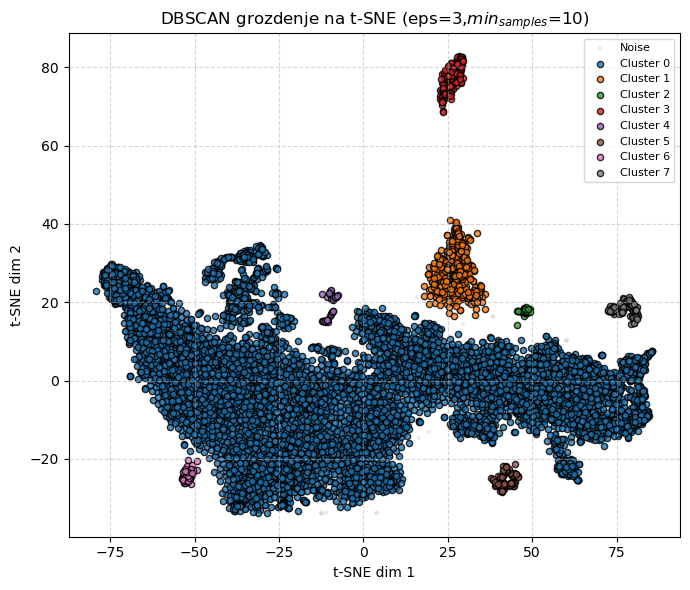

Cluster sizes: {0: 8957, 1: 463, 2: 31, 3: 215, 4: 45, 5: 93, -1: 17, 6: 55, 7: 123}

Running DBSCAN with eps=4, min_samples=15
 → Found 7 clusters (excluding noise)


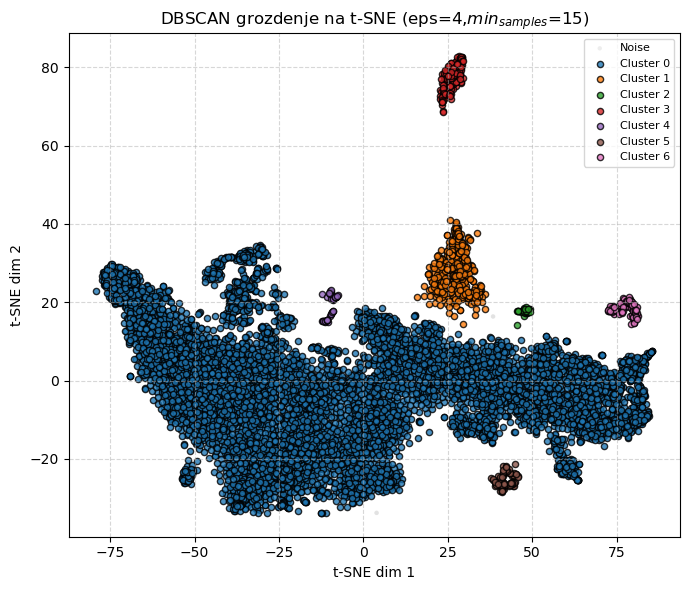

Cluster sizes: {0: 9022, 1: 465, 2: 31, 3: 215, 4: 45, 5: 93, 6: 123, -1: 5}

Classification file saved as dbscan_tsne_classification.txt


In [45]:
parameter_sets = [
    {"eps": 2, "min_samples": 5},
    {"eps": 3, "min_samples": 10},
    {"eps": 4, "min_samples": 15}
]

for params in parameter_sets:
    eps = params["eps"]
    min_samples = params["min_samples"]
    print(f"\nRunning DBSCAN with eps={eps}, min_samples={min_samples}")
    
    db = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = db.fit_predict(X_tsne)
    
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    print(f" → Found {n_clusters} clusters (excluding noise)")


    # VISUALIZE CLUSTERING RESULT
    
    plt.figure(figsize=(7,6))
    unique_clusters = np.unique(cluster_labels)
    for cl in unique_clusters:
        mask = cluster_labels == cl
        if cl == -1:
            plt.scatter(X_tsne[mask,0], X_tsne[mask,1],
                        color="lightgray", s=10, alpha=0.4, label="Noise", edgecolors='none')
        else:
            plt.scatter(X_tsne[mask,0], X_tsne[mask,1],
                        s=20, alpha=0.8, label=f"Cluster {cl}", edgecolors='k')
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.title(f"DBSCAN grozdenje na t-SNE (eps={eps}," +r"$min_{samples}$"+f"={min_samples})")
    plt.legend(markerscale=1, fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Count cluster membership
    counts = Counter(cluster_labels)
    print("Cluster sizes:", dict(counts))


# CHOOSE THE BEST PARAMETER SET

# After visual inspection, pick the DBSCAN parameters that give clear, distinct clusters.
# Example: eps=3, min_samples=10
best_db = DBSCAN(eps=3, min_samples=10).fit(X_tsne)
final_labels = best_db.labels_


# ASSIGN HUMAN-READABLE CATEGORIES

# You can manually assign meaningful names after inspecting the mean spectra of each cluster.
# For demonstration, assign automatic names:
cluster_names = {}
for cl in np.unique(final_labels):
    if cl == -1:
        cluster_names[cl] = "Šum"
    else:
        cluster_names[cl] = f"Grozd_{cl}"

# Create array of category names for each spectrum
category_labels = np.array([cluster_names[cl] for cl in final_labels])


# SAVE CLASSIFICATION FILE

output = np.column_stack([spec_ids, category_labels])
np.savetxt("dbscan_tsne_classification.txt", output, fmt="%s", header="spectrum_id category")

print("\nClassification file saved as dbscan_tsne_classification.txt")